Imports

In [1]:
import os
import time
import mne_connectivity
import numpy as np
import mne
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

Ensure Matplotlib uses the Qt5Agg backend for plotting functions

In [2]:
#  matplotlib.use('Qt5Agg')
annot_kwargs = dict(fontsize=12, fontweight='bold',
                    xycoords="axes fraction", ha='right', va='center')
fontsize = 8
params = {'font.size': fontsize,
          'axes.labelsize': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'axes.titlesize': fontsize + 2,
          'figure.max_open_warning': 200,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.grid': True,
          'lines.linewidth': 1
          }
plt.rcParams.update(params)

Configure to use Cuda

In [3]:
try:
    mne.set_config('MNE_USE_CUDA', 'true')
except TypeError as err:
    print(err)

Choose channels from the raw edf file to use

In [4]:
# good channels: [4,5,6,7,8,9,10,11,12,13,14,15,16,17]
# all channels ['TIME_STAMP_s', 'TIME_STAMP_ms', 'COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'HighBitFlex', 'SaturationFlag', 'RAW_CQ', 'BATTERY', 'BATTERY_PERCENT', 'MarkerIndex', 'MarkerType', 'MarkerValueInt', 'MARKER_HARDWARE', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_OVERALL', 'EQ_SampleRateQua', 'EQ_OVERALL', 'EQ_AF3', 'EQ_F7', 'EQ_F3', 'EQ_FC5', 'EQ_T7', 'EQ_P7', 'EQ_O1', 'EQ_O2', 'EQ_P8', 'EQ_T8', 'EQ_FC6', 'EQ_F4', 'EQ_F8', 'EQ_AF4', 'CQ_CMS', 'CQ_DRL']
stim_channels = ['MarkerValueInt', 'MarkerType']
exclude = ['MARKER_HARDWARE', 'MarkerIndex', 'TIME_STAMP_s', 'TIME_STAMP_ms', 'COUNTER', 'INTERPOLATED', 'HighBitFlex', 'SaturationFlag', 'RAW_CQ', 'BATTERY', 'BATTERY_PERCENT', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_OVERALL', 'EQ_SampleRateQua', 'EQ_OVERALL', 'EQ_AF3', 'EQ_F7', 'EQ_F3', 'EQ_FC5', 'EQ_T7', 'EQ_P7', 'EQ_O1', 'EQ_O2', 'EQ_P8', 'EQ_T8', 'EQ_FC6', 'EQ_F4', 'EQ_F8', 'EQ_AF4', 'CQ_CMS', 'CQ_DRL']
#  eog_channels = ['AF3', 'AF4']

Import EDFs

In [5]:
#  edf file name here
import_folder = 'Patrick and Josh Trial 3'
edf_file_name1 = 'EEG-Game_Josh Schrock_EPOCFLEX-F0000172_EPOCFLEX_123045_2022.08.05T14.35.40.04.00'
data_raw_file1 = f"{os.getcwd()}\\BCI Modified Chicken\\EEGExports\\{import_folder}\\{edf_file_name1}.edf"
raw1 = mne.io.read_raw_edf(data_raw_file1, stim_channel=stim_channels, exclude=exclude, preload=True)

edf_file_name2 = 'EEG-Game_Patrick_EPOCFLEX-F000015B_EPOCFLEX_123045_2022.08.05T14.35.40.04.00'
data_raw_file2 = f"{os.getcwd()}\\BCI Modified Chicken\\EEGExports\\{import_folder}\\{edf_file_name2}.edf"
raw2 = mne.io.read_raw_edf(data_raw_file2, stim_channel=stim_channels, exclude=exclude, preload=True)

Extracting EDF parameters from D:\Pycharm Projects\EEG-Game-V2\BCI Modified Chicken\EEGExports\Patrick and Josh Trial 3\EEG-Game_Josh Schrock_EPOCFLEX-F0000172_EPOCFLEX_123045_2022.08.05T14.35.40.04.00.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 65151  =      0.000 ...   508.992 secs...
Extracting EDF parameters from D:\Pycharm Projects\EEG-Game-V2\BCI Modified Chicken\EEGExports\Patrick and Josh Trial 3\EEG-Game_Patrick_EPOCFLEX-F000015B_EPOCFLEX_123045_2022.08.05T14.35.40.04.00.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 65151  =      0.000 ...   508.992 secs...


Set up the montage for this data

In [6]:
# Form the 10-20 montage
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_new = mont1020.copy()
# Keep only the desired channels
mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info

Apply montage to the raw data and plot

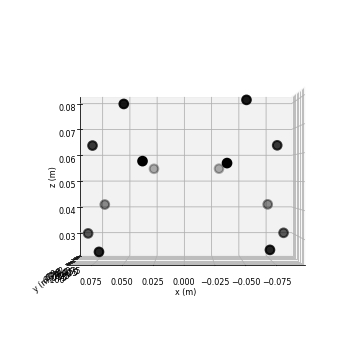

Using matplotlib as 2D backend.


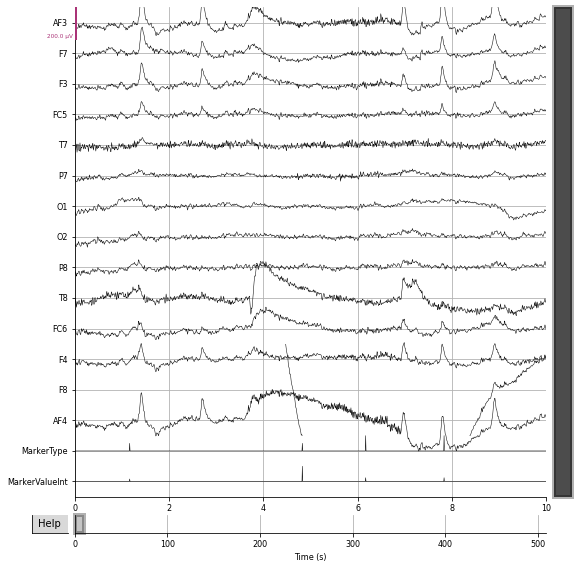

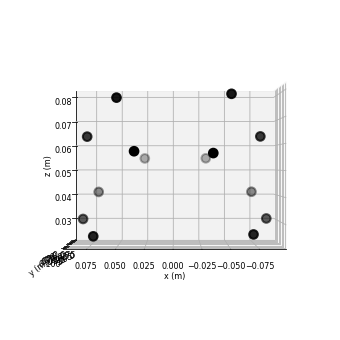

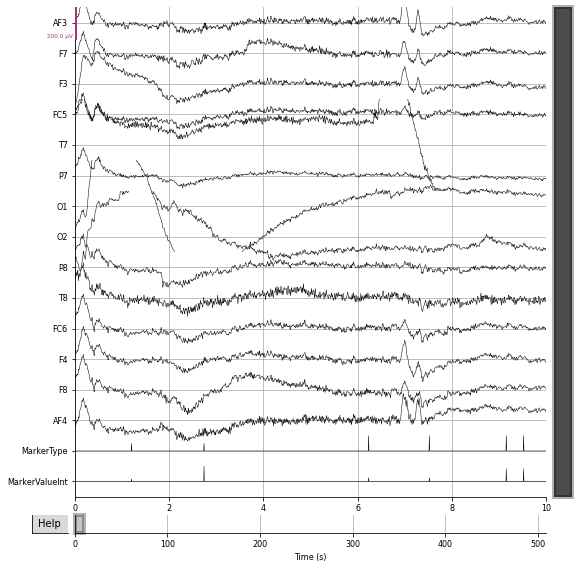

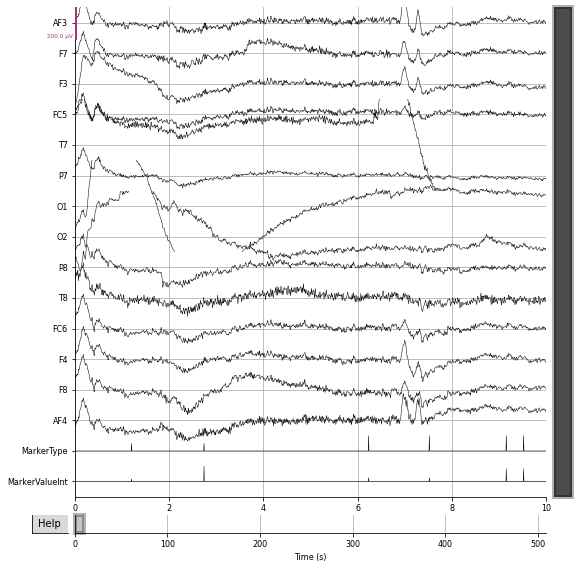

In [7]:
raw1.set_montage(mont1020_new)
raw1.plot_sensors(kind='3d', ch_type='eeg')
raw1.plot(scalings=0.0001)

raw2.set_montage(mont1020_new)
raw2.plot_sensors(kind='3d', ch_type='eeg')
raw2.plot(scalings=0.0001)

Preprocess Data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 845 samples (6.602 sec)

Effective window size : 16.000 (s)
Effective window size : 16.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\Joshu\PycharmProjects\venv\lib\site-packages\IPython\core\

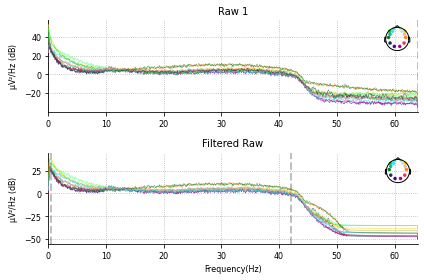

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 845 samples (6.602 sec)

Effective window size : 16.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 16.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


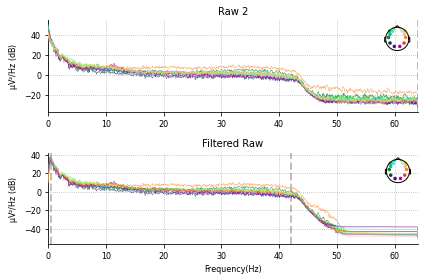

In [8]:
filtered_raw1 = raw1.copy().filter(
    0.5, 42, l_trans_bandwidth='auto', h_trans_bandwidth='auto',
    filter_length='auto', phase='zero', fir_window='hamming',
    fir_design='firwin')
fig, ax = plt.subplots(2)
raw1.plot_psd(ax=ax[0], show=False)
filtered_raw1.plot_psd(ax=ax[1], show=False)
ax[0].set_title('Raw 1')
ax[1].set_title('Filtered Raw')
ax[1].set_xlabel('Frequency(Hz)')
fig.set_tight_layout(True)
plt.show()

filtered_raw2 = raw2.copy().filter(
    0.5, 42, l_trans_bandwidth='auto', h_trans_bandwidth='auto',
    filter_length='auto', phase='zero', fir_window='hamming',
    fir_design='firwin')
fig, ax = plt.subplots(2)
raw2.plot_psd(ax=ax[0], show=False)
filtered_raw2.plot_psd(ax=ax[1], show=False)
ax[0].set_title('Raw 2')
ax[1].set_title('Filtered Raw')
ax[1].set_xlabel('Frequency(Hz)')
fig.set_tight_layout(True)
plt.show()

Perform ICA preprocessing

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.9s.


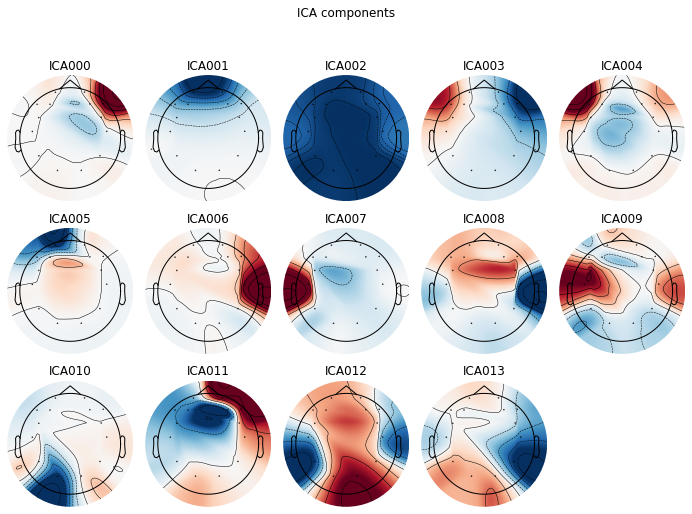

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.7s.


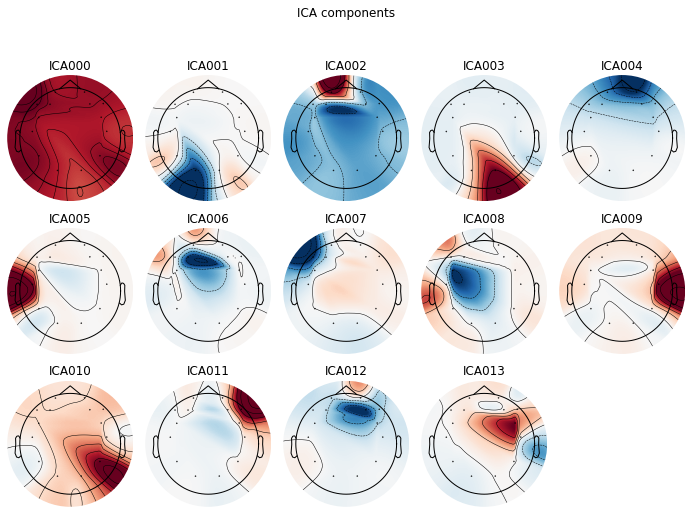

[<MNEFigure size 702x526.68 with 14 Axes>]

In [9]:
ica1 = mne.preprocessing.ICA(method='picard', n_components=14, random_state=0, max_iter=100000)
ica1.fit(filtered_raw1)
ica1.plot_components(outlines='skirt')

ica2 = mne.preprocessing.ICA(method='picard', n_components=14, random_state=0, max_iter=100000)
ica2.fit(filtered_raw2)
ica2.plot_components(outlines='skirt')

Extract bad channels

In [10]:
bad_idx1, scores1 = ica1.find_bads_eog(raw1.copy(), ch_name=['AF3', 'AF4'], threshold=2.7)
print(bad_idx1)

bad_idx2, scores2 = ica2.find_bads_eog(raw2.copy(), ch_name=['AF3', 'AF4'], threshold=2.7)
print(bad_idx2)

Using EOG channels: AF3, AF4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0

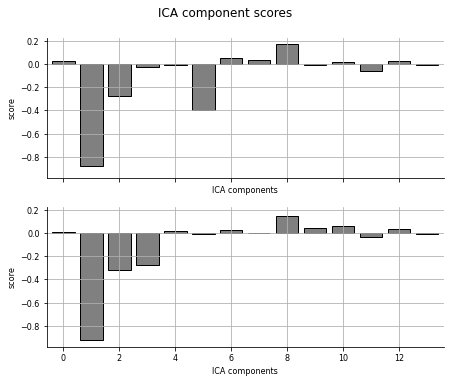

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated


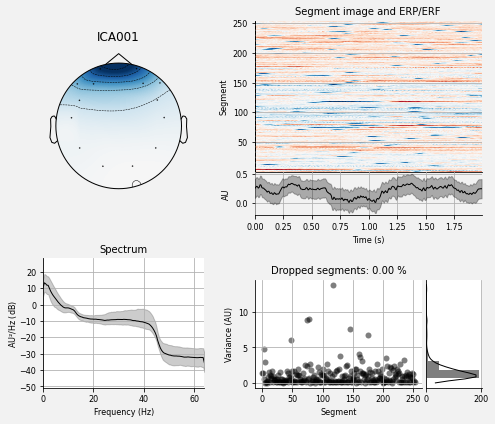

[1]
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components


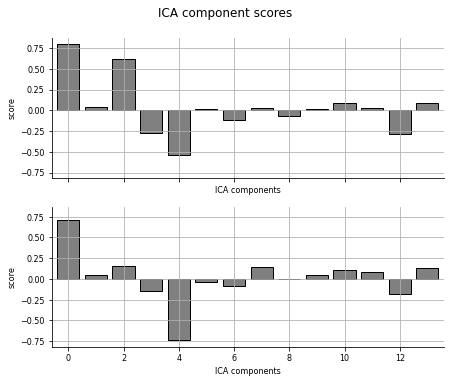

[]
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components


<RawEDF | EEG-Game_Patrick_EPOCFLEX-F000015B_EPOCFLEX_123045_2022.08.05T14.35.40.04.00.edf, 16 x 65152 (509.0 s), ~8.0 MB, data loaded>

In [11]:
# barplot of ICA component "ECG match" scores
ica1.plot_scores(scores1)

# plot diagnostics
if len(bad_idx1) > 0:
    ica1.plot_properties(raw1, picks=bad_idx1)

ica1.exclude=bad_idx1
print(ica1.exclude)
reconst_raw1 = raw1.copy()
ica1.apply(reconst_raw1)

# barplot of ICA component "ECG match" scores
ica2.plot_scores(scores2)

# plot diagnostics
if len(bad_idx2) > 0:
    ica2.plot_properties(raw2, picks=bad_idx2)

ica2.exclude=bad_idx2
print(ica2.exclude)
reconst_raw2 = raw2.copy()
ica2.apply(reconst_raw2)


Compare original to ICA filtered eeg data

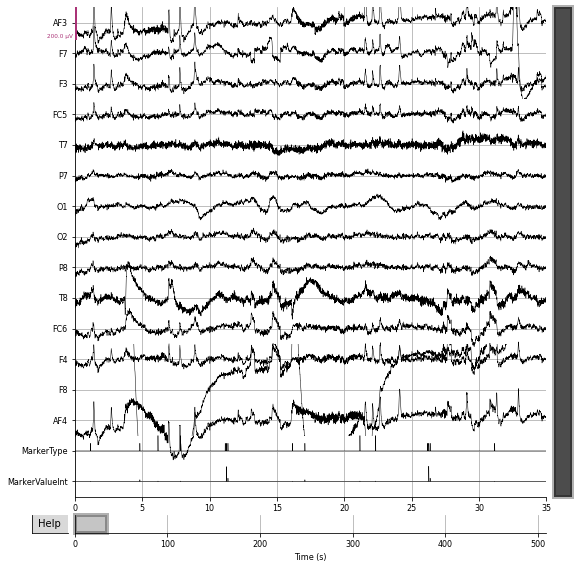

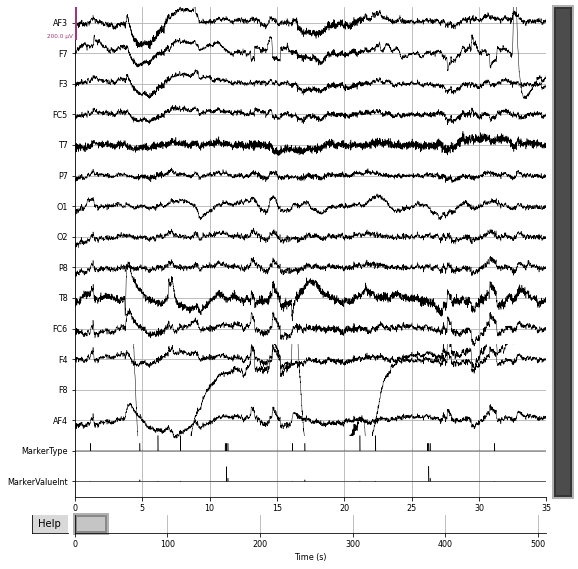

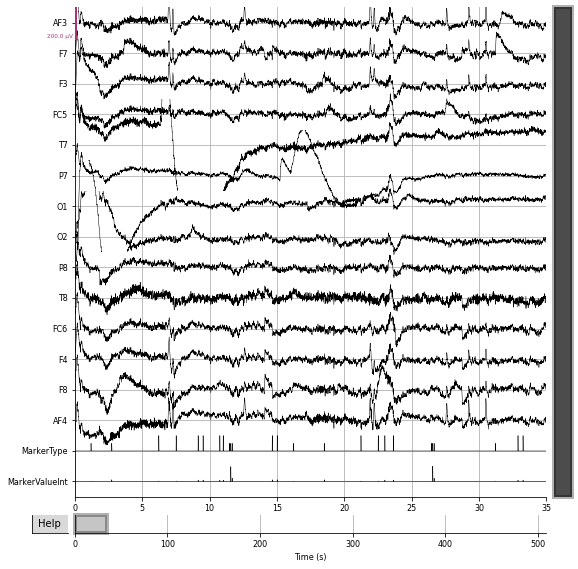

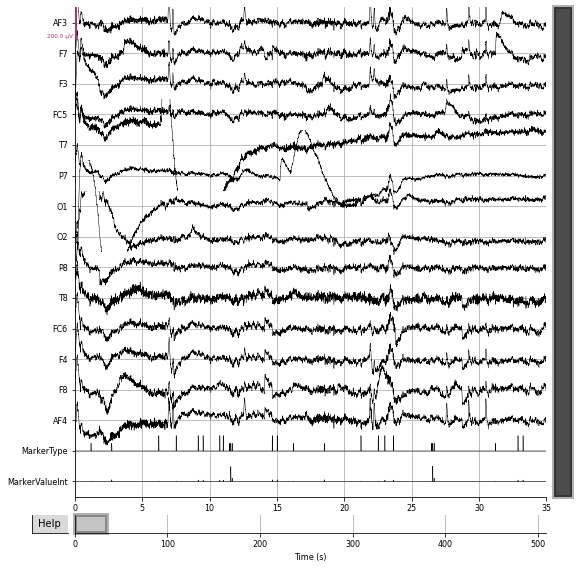

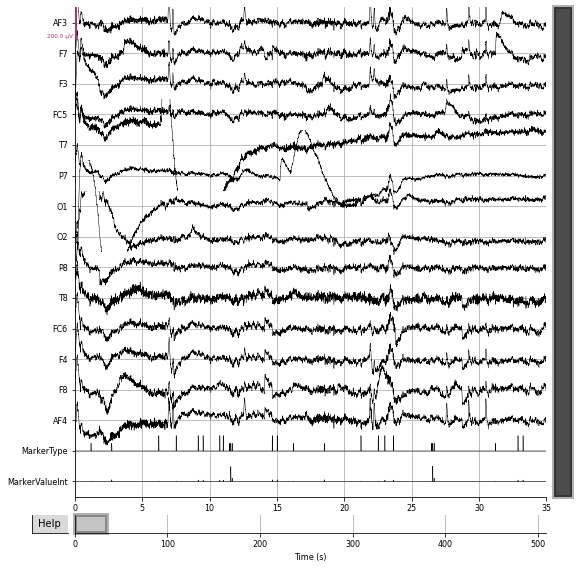

In [12]:
raw1.plot(scalings=0.0001, duration=35)
reconst_raw1.plot(scalings=0.0001, duration=35)

raw2.plot(scalings=0.0001, duration=35)
reconst_raw2.plot(scalings=0.0001, duration=35)

Perform DMD using data from t0 to t1 to get temporal dynamics matrix

KeyboardInterrupt: 

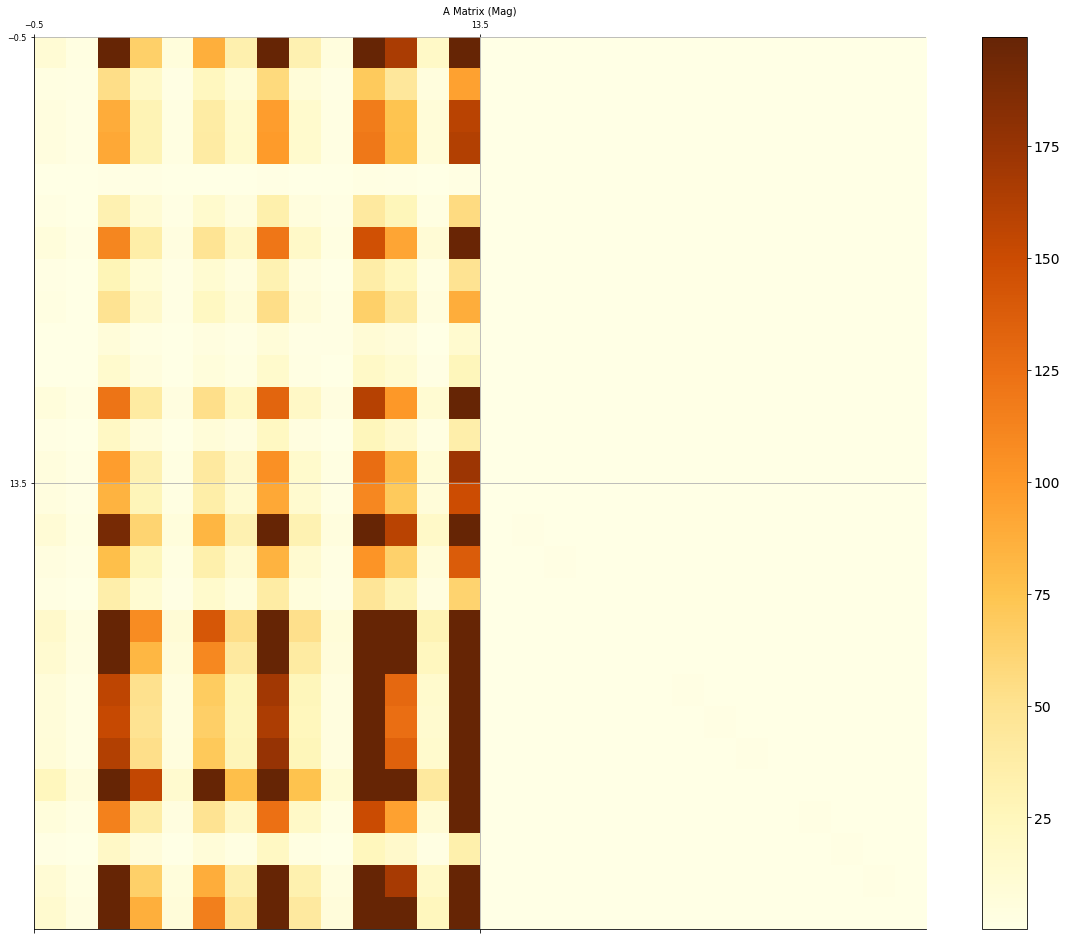

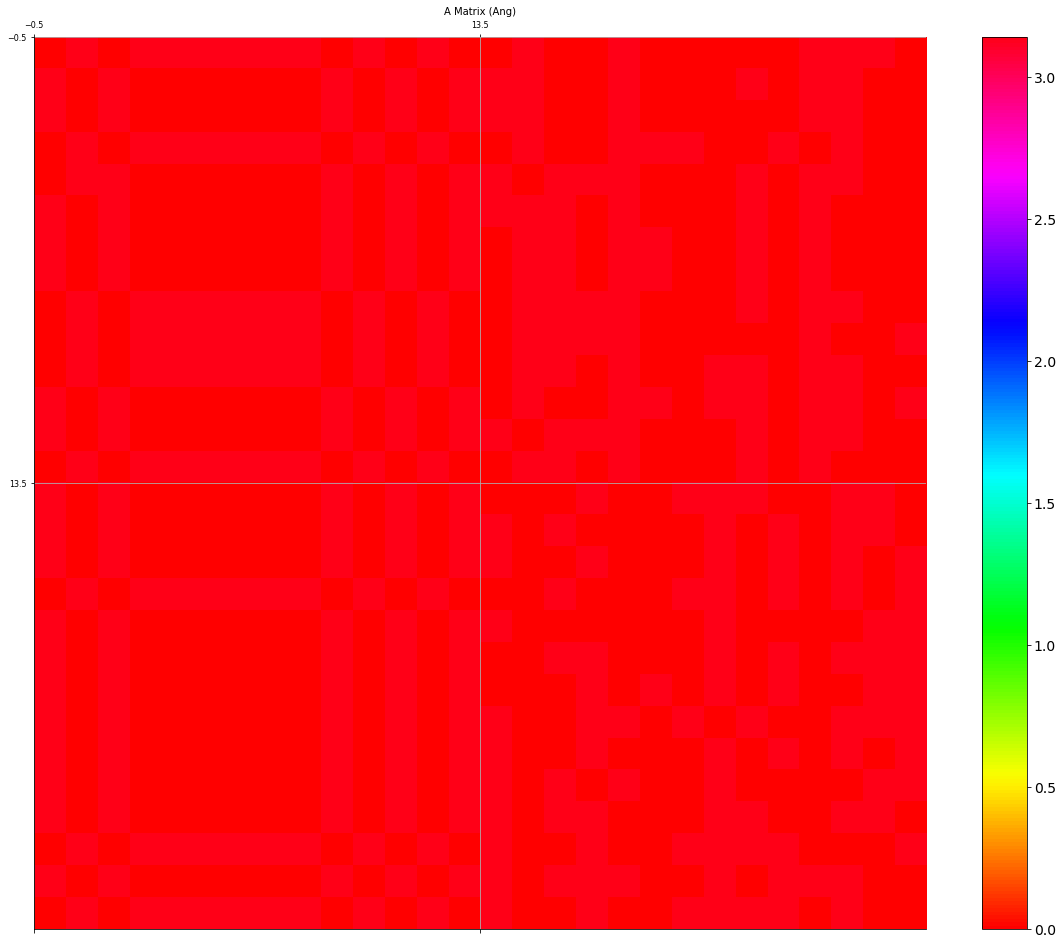

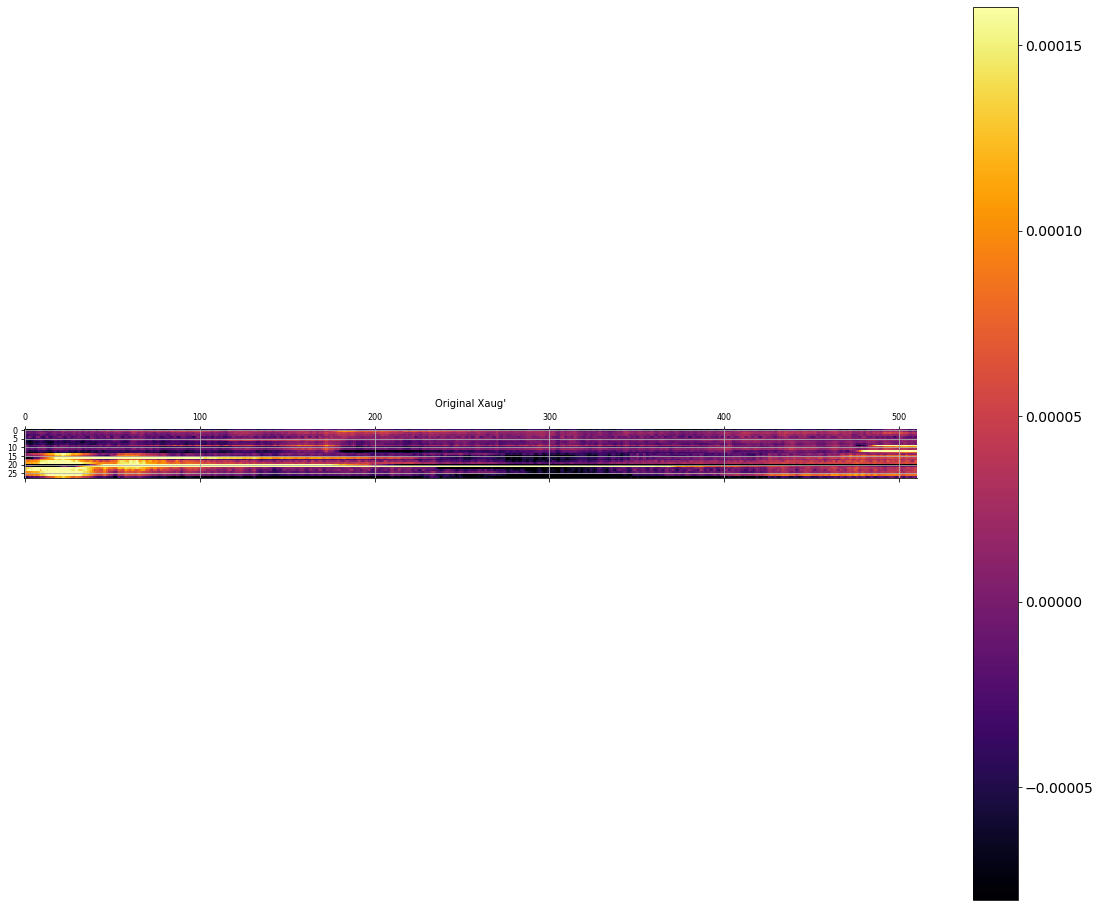

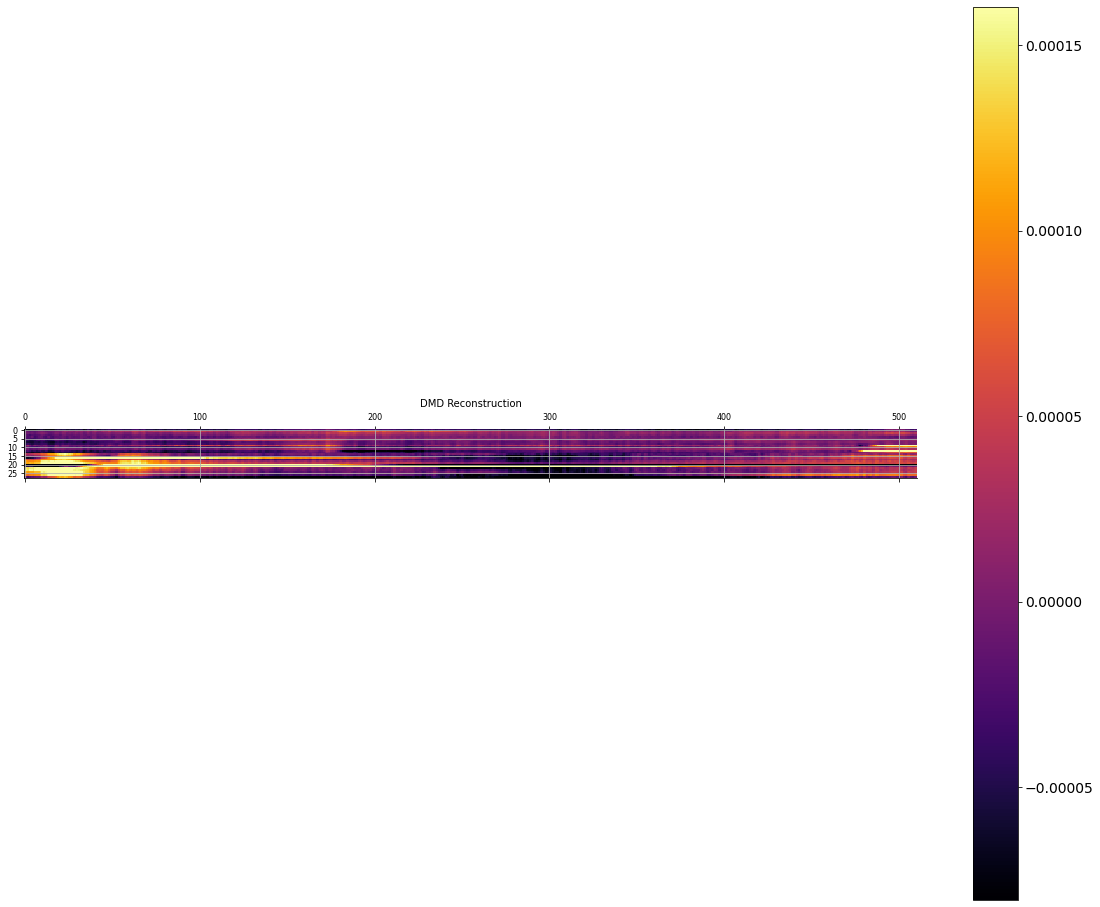

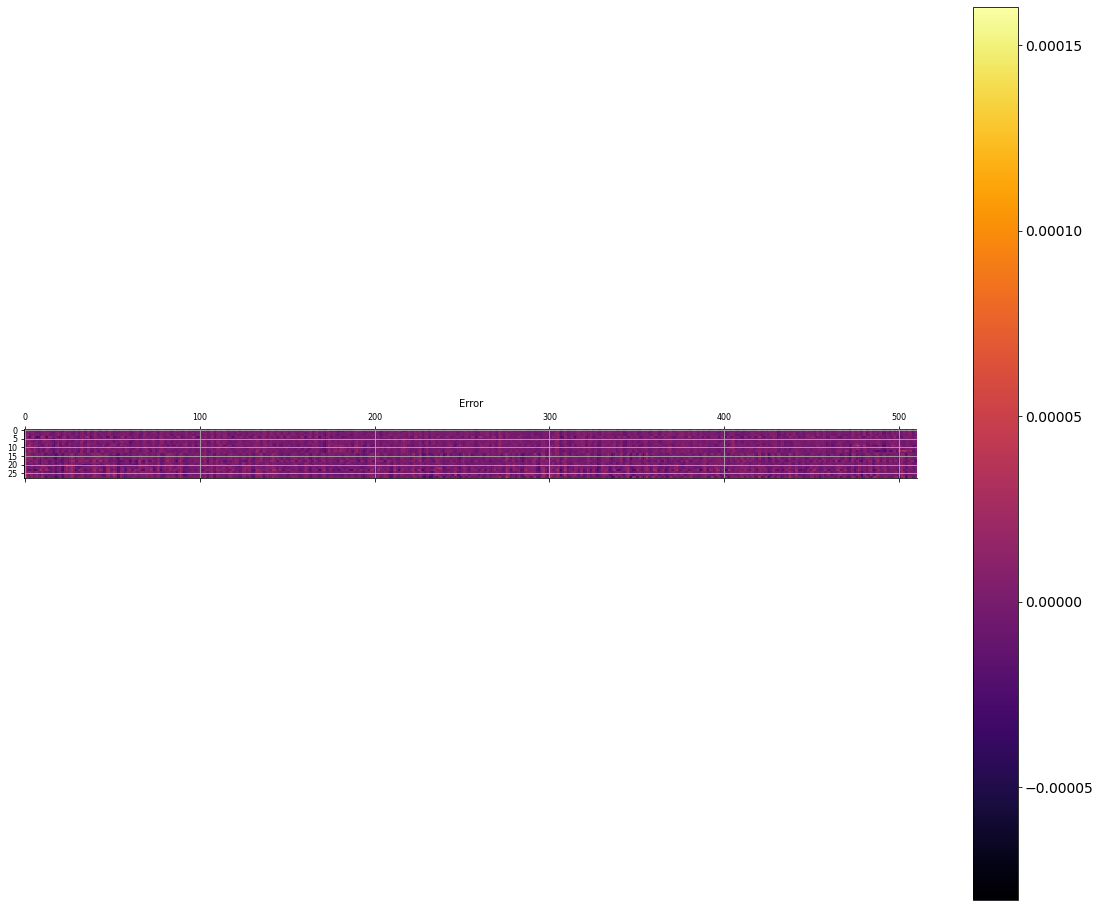

In [13]:
from DataToDynamicsCombined import Datatodynamicscombined

data1 = reconst_raw1.get_data(picks='eeg')
data2 = reconst_raw2.get_data(picks='eeg')

s1 = 512
s0 = s1 - 512
ds = 1
dynamics = Datatodynamicscombined(data1, data2, s0, s1, aug=False)
dynamics.DMDalt(plot=True)
dynamics.reconstructalt(plot=True)
matricies = np.zeros((1, dynamics.A.shape[0], dynamics.A.shape[1]))
matricies[0] = dynamics.A
s1 += ds

while s1 < min(data1.shape[1], data2.shape[1]):
    s0 = s1 - 512
    dynamics = Datatodynamicscombined(data1, data2, s0, s1, aug=False)
    dynamics.DMDalt(plot=False)
    matricies = np.concatenate((matricies, dynamics.A[np.newaxis,:,:]), axis=0)
    s1 += ds


export_name = 'A-Matricies'
# make dir
new_dir = f'{os.getcwd()}\\DynamicsNetExports\\{import_folder}'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
np.save(f'{new_dir}\\{export_name}', matricies)


In [13]:
from DynamicsToNetwork import Dynamicstonetwork
import_folder = 'Patrick and Josh Trial 3'

name = 'EEG-Game_Josh Schrock_EPOCFLEX-F0000172_1659725050.2875884_actions.npy'
new_dir = f'{os.getcwd()}\\BCI Modified Chicken\\EEGExports\\{import_folder}\\{name}'
info1 = np.load(new_dir)

name = 'EEG-Game_Patrick_EPOCFLEX-F000015B_1659725050.2905793_actions.npy'
new_dir = f'{os.getcwd()}\\BCI Modified Chicken\\EEGExports\\{import_folder}\\{name}'
info2 = np.load(new_dir)

export_name = 'A-Matricies'
# make dir
new_dir = f'{os.getcwd()}\\DynamicsNetExports\\{import_folder}'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)


stimdata1 = reconst_raw1.pick_types(stim=True).get_data(picks='all')[:,512:]
stimdata2 = reconst_raw2.pick_types(stim=True).get_data(picks='all')[:,512:]

matricies = np.load(f'{new_dir}\\{export_name}.npy')

network = Dynamicstonetwork(matricies, stimdata1, stimdata2, info1, info2)
network.export(import_folder, downsp=4)

In [14]:
import cv2
image_folder = f'{new_dir}\\Chuncks'
video_name = f'{new_dir}\\Net_of_{export_name}.avi'
downsp = 4

images = []
for i in range(matricies.shape[0]):
    if i % downsp == 0:
        images.append(f'{image_folder}\\{str(i)}.png')
frame = cv2.imread(images[0])
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 128//downsp, (width, height))

for image in images:
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()